In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 17, 'figure.figsize': [15, 7]})

## Net electricity consumption w/o storage prediction from memory - comparing loss functions

This is an appendix notebook to the 'net_consumption_dot_product' one.

In [9]:
net_consumption_df = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
for i in range (len(net_consumption_df), len(net_consumption_df) + 3):
    net_consumption_df.loc[i] = 0
net_consumption_vec = net_consumption_df.to_numpy().T.flatten()
net_consumption_vec = np.append(np.zeros(3), net_consumption_vec)
# there is a small bug here, duplicated from the original notebook. We use 3-sized padding instead of 23. But I keep it for consistency.

masking_ratio = 0.3
mask_len = int(len(net_consumption_vec) * masking_ratio)

idx_post = np.arange(len(net_consumption_vec) - mask_len + 24, len(net_consumption_vec) - 48)

weights_for_loss = np.exp( - np.arange(0, 24) / 12) / sum(np.exp( - np.arange(0, 24) / 12))

results_df = pd.read_csv("data/post_mask.csv", index_col=0)
results_df["idx"] = idx_post
results_df.head()

,uncertainty,certainty,mae_24,rmse_24,mdpe_24,mae_combined,rmse_combined,mdpe_combined,idx
0,0.101652,0.898348,0.803464,0.876228,0.931403,0.799730,0.805713,0.802349,30697
1,0.086733,0.913267,0.848741,0.879453,0.933988,0.747919,0.794848,0.830814,30698
2,0.091119,0.908881,0.893226,0.884281,0.937137,0.813268,0.756654,0.640035,30699
3,0.064618,0.935382,0.742435,0.783149,0.622760,0.798992,0.786058,0.605993,30700
4,0.061436,0.938564,0.777411,0.784114,0.609389,0.785929,0.784620,0.610395,30701


In [10]:
def predict_next_24h_masked(input_vec: np.ndarray, ratio: float) -> np.ndarray:
    """
    Predict the next day consumption from the previous 24 hours
    Args:
        input_vec (np.array): the vector of the net consumption, len=24
        ratio (float): the ratio of the input vector to be masked
    """

    assert len(input_vec) == 24, "The input vector must be of length 24"

    input_vec = input_vec / np.sqrt(sum(input_vec ** 2))

    net_consumption = np.load('data/net_consumption_24.npy')
    norm_vec = np.load('data/net_consumption_norm24.npy')

    mask_length = int(len(net_consumption) * ratio)
    net_consumption = net_consumption[:-mask_length]
    norm_vec = norm_vec[:-mask_length]

    correlation = np.array([np.sum(input_vec * net_consumption[i:i+24]) for i in range(len(net_consumption)-47)])
    correlation /= norm_vec

    idx_from_correlation = np.argmax(correlation)
    prediction = net_consumption[idx_from_correlation+24:idx_from_correlation+48]

    return prediction

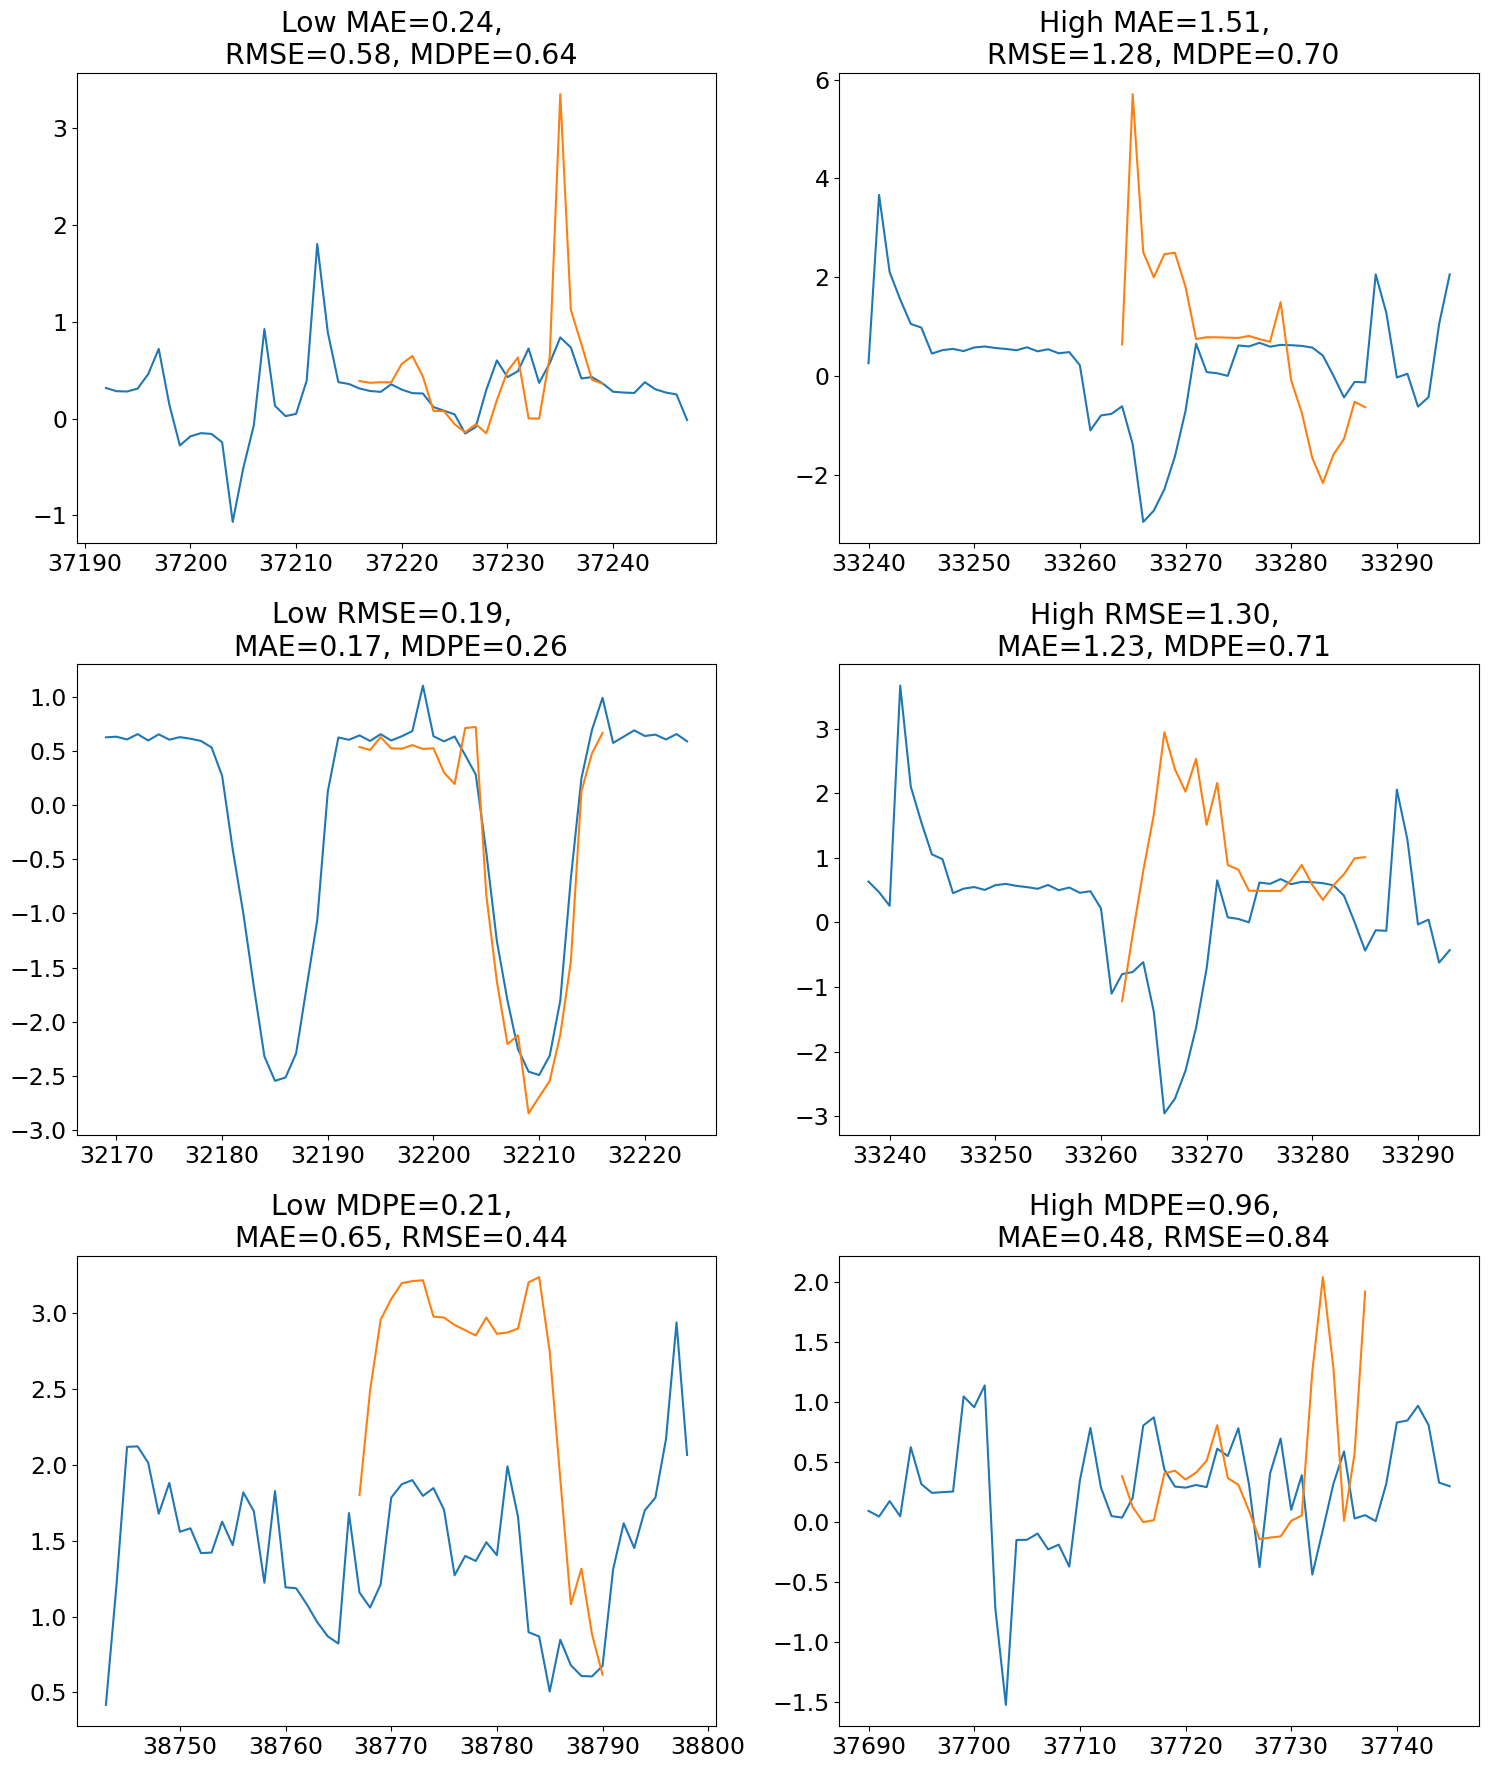

In [24]:
low_mae = np.argsort(results_df["mae_24"].values * 4 - results_df["rmse_24"].values - results_df["mdpe_24"].values)[2]
high_mae = np.argsort(results_df["mae_24"].values * 4 - results_df["rmse_24"].values - results_df["mdpe_24"].values)[-3]
low_rmse = np.argsort(results_df["rmse_24"].values * 4 - results_df["mae_24"].values - results_df["mdpe_24"].values)[120]
high_rmse = np.argsort(results_df["rmse_24"].values * 4 - results_df["mae_24"].values - results_df["mdpe_24"].values)[-3]
low_mdpe = np.argsort(results_df["mdpe_24"].values * 4 - results_df["mae_24"].values - results_df["rmse_24"].values)[0]
high_mdpe = np.argsort(results_df["mdpe_24"].values * 4 - results_df["mae_24"].values - results_df["rmse_24"].values)[-3]

fig, axs = plt.subplots(3, 2, figsize=(15, 18))

axs[0, 0].plot(range(idx_post[low_mae], idx_post[low_mae] + 56), net_consumption_vec[idx_post[low_mae]:idx_post[low_mae] + 56])
axs[0, 0].plot(range(idx_post[low_mae] + 24, idx_post[low_mae] + 48), predict_next_24h_masked(net_consumption_vec[idx_post[low_mae]:idx_post[low_mae] + 24], masking_ratio))
axs[0, 0].title.set_text(f"Low MAE={results_df['mae_24'].values[low_mae]:.2f}, \n RMSE={results_df['rmse_24'].values[low_mae]:.2f}, MDPE={results_df['mdpe_24'].values[low_mae]:.2f}")

axs[0, 1].plot(range(idx_post[high_mae], idx_post[high_mae] + 56), net_consumption_vec[idx_post[high_mae]:idx_post[high_mae] + 56])
axs[0, 1].plot(range(idx_post[high_mae] + 24, idx_post[high_mae] + 48), predict_next_24h_masked(net_consumption_vec[idx_post[high_mae]:idx_post[high_mae] + 24], masking_ratio))
axs[0, 1].title.set_text(f"High MAE={results_df['mae_24'].values[high_mae]:.2f}, \n RMSE={results_df['rmse_24'].values[high_mae]:.2f}, MDPE={results_df['mdpe_24'].values[high_mae]:.2f}")

axs[1, 0].plot(range(idx_post[low_rmse], idx_post[low_rmse] + 56), net_consumption_vec[idx_post[low_rmse]:idx_post[low_rmse] + 56])
axs[1, 0].plot(range(idx_post[low_rmse] + 24, idx_post[low_rmse] + 48), predict_next_24h_masked(net_consumption_vec[idx_post[low_rmse]:idx_post[low_rmse] + 24], masking_ratio))
axs[1, 0].title.set_text(f"Low RMSE={results_df['rmse_24'].values[low_rmse]:.2f}, \n MAE={results_df['mae_24'].values[low_rmse]:.2f}, MDPE={results_df['mdpe_24'].values[low_rmse]:.2f}")

axs[1, 1].plot(range(idx_post[high_rmse], idx_post[high_rmse] + 56), net_consumption_vec[idx_post[high_rmse]:idx_post[high_rmse] + 56])
axs[1, 1].plot(range(idx_post[high_rmse] + 24, idx_post[high_rmse] + 48), predict_next_24h_masked(net_consumption_vec[idx_post[high_rmse]:idx_post[high_rmse] + 24], masking_ratio))
axs[1, 1].title.set_text(f"High RMSE={results_df['rmse_24'].values[high_rmse]:.2f}, \n MAE={results_df['mae_24'].values[high_rmse]:.2f}, MDPE={results_df['mdpe_24'].values[high_rmse]:.2f}")

axs[2, 0].plot(range(idx_post[low_mdpe], idx_post[low_mdpe] + 56), net_consumption_vec[idx_post[low_mdpe]:idx_post[low_mdpe] + 56])
axs[2, 0].plot(range(idx_post[low_mdpe] + 24, idx_post[low_mdpe] + 48), predict_next_24h_masked(net_consumption_vec[idx_post[low_mdpe]:idx_post[low_mdpe] + 24], masking_ratio))
axs[2, 0].title.set_text(f"Low MDPE={results_df['mdpe_24'].values[low_mdpe]:.2f}, \n MAE={results_df['mae_24'].values[low_mdpe]:.2f}, RMSE={results_df['rmse_24'].values[low_mdpe]:.2f}")

axs[2, 1].plot(range(idx_post[high_mdpe], idx_post[high_mdpe] + 56), net_consumption_vec[idx_post[high_mdpe]:idx_post[high_mdpe] + 56])
axs[2, 1].plot(range(idx_post[high_mdpe] + 24, idx_post[high_mdpe] + 48), predict_next_24h_masked(net_consumption_vec[idx_post[high_mdpe]:idx_post[high_mdpe] + 24], masking_ratio))
axs[2, 1].title.set_text(f"High MDPE={results_df['mdpe_24'].values[high_mdpe]:.2f}, \n MAE={results_df['mae_24'].values[high_mdpe]:.2f}, RMSE={results_df['rmse_24'].values[high_mdpe]:.2f}")

fig.tight_layout()
plt.show()


We find that weighted and normalized RMSE would be the best choice as it captures the overall trend better than MAE and MDPE. Also a lot of good examples have low RMSE, which is not true for the other losses - note that here we picked the best MDPE, second-best MAE and 121-best RMSE, and still the RMSE is lower than the other two.